# Working with keras - a deep dive
### 7.2.1 The sequential class.

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

Or incrementally building a Sequential model.

In [8]:
# exactly same with the model above

model = keras.Sequential()
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

But right now, the model that aren't yet built have no weights until the input shape is known.

In [ ]:
# Weights for model sequential_4 have not yet been created

model.weights

Calling a model for the first time to build it.

In [ ]:
# Then we can have initial weight

model.build(input_shape=(None, 3))
model.weights

1. Builds the model - now the model will expect samples of shape (3, ). The None in the input shape signals that the batch size could be anything.
2. Now we can retrieve the model's weights.

After model is built, we can display its content via $summary()$ method.

In [12]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 64)                256       
_________________________________________________________________
dense_9 (Dense)              (None, 10)                650       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


As we can see our model happens to be named "sequential_4". We can actually give names to everything in Keras—every model, every layer. Like this:

In [14]:
model = keras.Sequential(name="example_model")
model.add(layers.Dense(64, activation="relu", name="my_first_layer"))
model.add(layers.Dense(10, activation="softmax", name="my_last_layer"))
model.build((None, 3))

model.summary()

Model: "example_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_first_layer (Dense)       (None, 64)                256       
_________________________________________________________________
my_last_layer (Dense)        (None, 10)                650       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


Declare the shape of the model's inputs in advance. You can do this via the $Input$ class:

In [ ]:
model = keras.Sequential()
model.add(keras.Input(shape=(3, )))
model.add(layers.Dense(64, activation='relu'))

$*$ Use an $Input$ to declare the shape of the inputs. Note that the $shape$ argument must be the __shape of each sample__, not the shape of one batch.
### 7.2.2 The Functional API
In practice, it's pretty common to encounter models with multiple inputs (say, an image and its metadata), multiple outputs (different outputs we want to predict about the data). In such case, we will use the Functional API, where it's the most Keras models we'll encounter in the wild use.

A simple example:

In [27]:
inputs = keras.Input(shape=(3, ), name='my_input')
features = layers.Dense(64, activation='relu')(inputs)
outputs = layers.Dense(10, activation='softmax')(features)

model = keras.Model(inputs=inputs, outputs=outputs)

Let's go over step by step.

We started by declaring an $Input$.

In [29]:
inputs.shape

TensorShape([None, 3])

In [31]:
inputs.dtype

tf.float32

1. The model will process batches where each sample has shape (3, ). The number of sample per batch is variable (indicated by the None batch size).
2. These batches will have dtype: float32.

We call such an object a "symbolic tensor". It doesn’t contain any actual data, but it encodes the specifications of the actual tensors of data that the model will see when you use it. It stands for future tensors of data.

In [32]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_input (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)                256       
_________________________________________________________________
dense_16 (Dense)             (None, 10)                650       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


Multi-input, multi-output models

Most deep learning models look like graphs. They may have multiple inputs and multiple outputs.

Let’s say you’re building a system to rank customer support tickets by priority and route them to the appropriate department. Your model has three inputs:
1. The title of the ticket (text input)
2. The text body of the ticket (text input)
3. Any tags added by the user (categorical input, assumed here to be one-hot encoded)

We can encode the text inputs as arrays of ones and zeros of size vocabulary_size. Your model also has two outputs:
1. The priority score of the ticket, a scalar between 0 and 1 (sigmoid output)
2. The department that should handle the ticket (a softmax over the set of departments)


In [33]:
vocabulary_size = 10000
num_tags = 100
num_departments = 4

# input: title, text body, tags.
title = keras.Input(shape=(vocabulary_size,), name="title")
text_body = keras.Input(shape=(vocabulary_size,), name="text_body") 
tags = keras.Input(shape=(num_tags,), name="tags")

# Combine input features into a single tensor, features, by concatenating them.
features = layers.Concatenate()([title, text_body, tags])
# Apply intermediate layer to recombine input features into richer representations.
features = layers.Dense(64, activation="relu")(features)

# output: priority, department.
priority = layers.Dense(1, activation="sigmoid", name="priority")(features) 
department = layers.Dense(num_departments, activation="softmax", name="department")(features)

model = keras.Model(inputs=[title, text_body, tags], outputs=[priority, department])

Training a multi-input, multi-output model.

In [ ]:
import numpy as np

num_samples = 1280

# dummy input data
title_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
text_body_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size)) 
tags_data = np.random.randint(0, 2, size=(num_samples, num_tags))

# dummy output data
priority_data = np.random.random(size=(num_samples, 1))
department_data = np.random.randint(0, 2, size=(num_samples, num_departments))

model.compile(optimizer="adam",
              loss=["mean_squared_error", "categorical_crossentropy"],
              metrics=[["mean_absolute_error"], ["accuracy"]])

model.fit([title_data, text_body_data, tags_data],
          [priority_data, department_data], epochs=1)

model.evaluate([title_data, text_body_data, tags_data],
               [priority_data, department_data])

priority_preds, department_preds = model.predict([title_data, text_body_data, tags_data])

If we don’t want to rely on input order (for instance because you have many inputs or outputs), we can also leverage the names we gave to the objects and to the output layers, and pass Input data via dictionaries:

In [ ]:
model.compile(optimizer="adam",
              loss={"priority": "mean_squared_error", "department": "categorical_crossentropy"},
              metrics={"priority": ["mean_absolute_error"], "department": ["accuracy"]})

model.fit({"title": title_data, "text_body": text_body_data, "tags": tags_data},
          {"priority": priority_data, "department": department_data},epochs=1)

model.evaluate({"title": title_data, "text_body": text_body_data, "tags": tags_data},
               {"priority": priority_data, "department": department_data})

priority_preds, department_preds = model.predict(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data})

The power of Functional API: access to layer connectivity.

A Functional model is an explicit graph data structure. This makes it possible to __inspect how layers are connected__ and __reuse previous graph nodes__ (which are layer outputs) as part of new models.

Plotting layer connectivity.

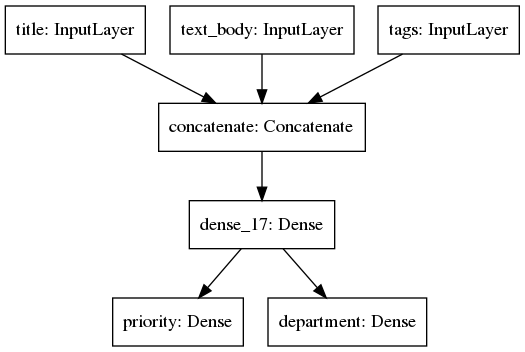

In [39]:
keras.utils.plot_model(model, 'layer_connectivity.png')

We can also show the shape.

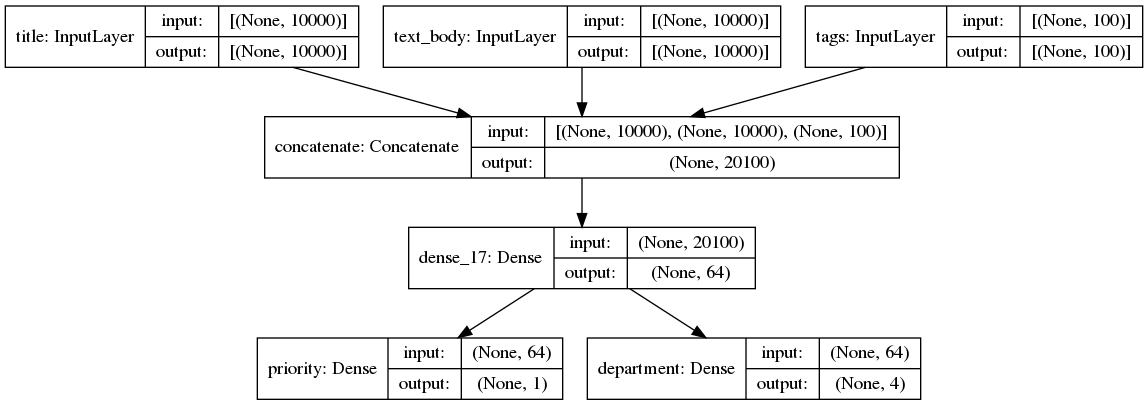

In [42]:
keras.utils.plot_model(model, 'layer_connectivity_with_shape.png', show_shapes=True)

"None" in the tensor shapes represents the batch size: this model allows batches of any size.

Feature extraction with a functional model

In [43]:
model.layers

In [44]:
model.layers[3].input

[<KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'title')>,
 <KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'text_body')>,
 <KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'tags')>]

In [45]:
model.layers[3].output

<KerasTensor: shape=(None, 20100) dtype=float32 (created by layer 'concatenate')>

This feature enables us to do *feature extraction*: creating models that reuse intermediate features from another model.

Creating a new model by reusing intermediate layer outputs:

In [50]:
features = model.layers[4].output
difficulty = layers.Dense(3, activation="softmax", name="difficulty")(features)

new_model = keras.Model(
    inputs=[title, text_body, tags],
    outputs=[priority, department, difficulty])

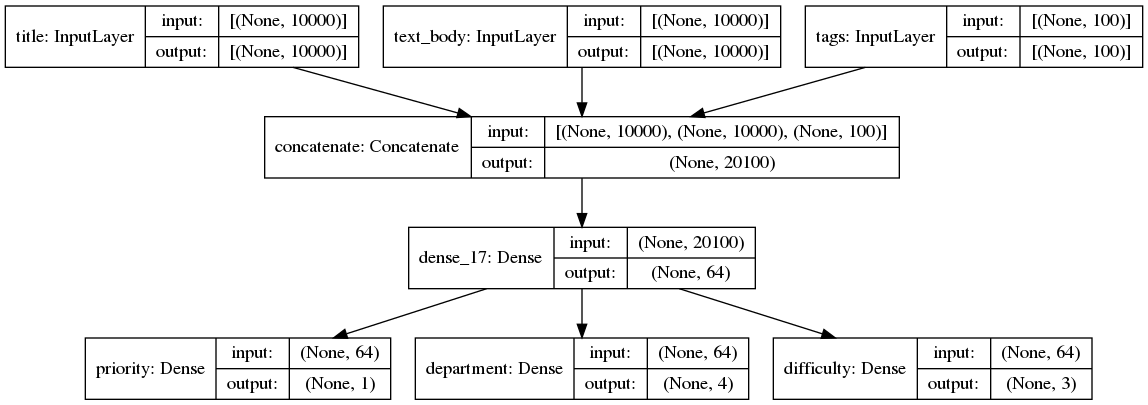

In [51]:
keras.utils.plot_model(new_model, "updated_ticket_classifier.png", show_shapes=True)

### 7.2.3 Subclassing the *model* class

## 7.3 Using built-in training and evaluation loops